# **Secura - Steganography Using Generative Adversarial Networks**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Necessary imports and fucntion definitions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Model
from keras.layers import Conv2D, Input, AveragePooling2D, Dense, Reshape, Lambda,MaxPooling2D, Concatenate
from keras.layers import LeakyReLU, Add, BatchNormalization, Rescaling, Activation, Flatten


input_shape = (256,256,3)
image_size = 256


batch_size = 20
epochs = 200

cover_image_dir = './lite_set/cover_images/'
secret_image_dir = './lite_set/secret_images'

# fucntion to load the cover and secret images as batches
# returns  two variables: cover_images and secret Images
def load_data():
  cover_images =  tf.keras.utils.image_dataset_from_directory(
                    cover_image_dir,
                    validation_split=0,
                    shuffle=True,
                    label_mode=None,
                    image_size=(image_size,image_size),
                    batch_size=batch_size)

  secret_images =  tf.keras.utils.image_dataset_from_directory(
                    secret_image_dir,
                    validation_split=0,
                    shuffle=True,
                    label_mode=None,
                    image_size=(image_size,image_size),
                    batch_size=batch_size)

  normalization_layer = Rescaling(1./127.5, offset=-1)

  cover_images = cover_images.map(lambda x: (normalization_layer(x)))
  secret_images = secret_images.map(lambda x: (normalization_layer(x)))

  AUTOTUNE = tf.data.AUTOTUNE
  cover_images = cover_images.cache().prefetch(buffer_size=AUTOTUNE)
  secret_images = secret_images.cache().prefetch(buffer_size=AUTOTUNE)

  return cover_images,secret_images


def InceptionBlock(filters_in, filters_out):
    input_layer = Input(shape=(image_size, image_size, filters_in))  # Adjusted input shape

    tower_filters = int(filters_out / 4)

    tower_1 = Conv2D(tower_filters, 1, padding='same', activation='relu')(input_layer)

    tower_2 = Conv2D(tower_filters, 1, padding='same', activation='relu')(input_layer)
    tower_2 = Conv2D(tower_filters, 3, padding='same', activation='relu')(tower_2)

    tower_3 = Conv2D(tower_filters, 1, padding='same', activation='relu')(input_layer)
    tower_3 = Conv2D(tower_filters, 5, padding='same', activation='relu')(tower_3)

    tower_4 = MaxPooling2D(pool_size=(1, 1), padding='same', strides=(1, 1))(input_layer)
    tower_4 = Conv2D(tower_filters, 1, padding='same', activation='relu')(tower_4)

    concat = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])

    # Adjusted the number of filters in the Conv2D layer to match concat
    res_link = Conv2D(filters_out, 1, padding='same', activation='relu')(input_layer)

    output = Add()([concat, res_link])
    output = Activation('relu')(output)

    model_output = Model(inputs=input_layer, outputs=output)
    return model_output



### Class Definition


In [ ]:
class SimplifiedSteganographyGAN(object):
  def __init__(self):
    self.generator = self.build_generator(input_shape)

    # Generate discriminator model
    self.discriminator = self.build_discriminator(input_shape)

    # Compile discriminator
    self.discriminator.compile(optimizer='adam', loss='binary_crossentropy')

    # Generate adversarial model
    cover_image = Input(shape=(256, 256, 3), name="Cover_Image_Input")
    secret_image = Input(shape=(256, 256,3), name="Secret_Image_Input")
    stego_image, reconstructed_image = self.generator([cover_image, secret_image])

    # For the adversarial model, we do not train the discriminator
    self.discriminator.trainable = False

    # The discriminator determines the security of the stego image
    security = self.discriminator(stego_image)

    # Define a coef for the contribution of discriminator loss to total loss
    g = 0.001

    # Build and compile the adversarial model
    self.adversarial = Model(inputs=[cover_image, secret_image], \
                              outputs=[stego_image, reconstructed_image, security], name="Steganography_GAN")

    self.adversarial.compile(optimizer='adam',loss=['mse', 'mse', 'binary_crossentropy'],loss_weights=[1.0, 0.85, g])


    self.adversarial.summary()
    self.history = {'epoch':[], 'd_loss': [], 'g_loss': []}

  def build_generator(self,input_shape):
    # Inputs design
    cover_input = Input(shape=input_shape, name='cover_input')
    secret_input = Input(shape=input_shape, name='secret_input')

    combined_input = Concatenate(axis=-1)([cover_input, secret_input])

    x = Conv2D(16, (3, 3), padding='same')(combined_input)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)

    x = InceptionBlock(16, 32)(x)
    x = InceptionBlock(32, 64)(x)
    x = InceptionBlock(64, 128)(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)
    stego = Conv2D(3, (1, 1), padding='same', activation='tanh', name="stego_image")(x)

    encoder_output = stego

    # Decoder architecture
    depth = 32
    L1 = Conv2D(depth, 3, padding='same')(stego)
    L1 = BatchNormalization(momentum=0.9)(L1)
    L1 = LeakyReLU(alpha=0.2)(L1)

    L2 = Conv2D(depth*2, 3, padding='same')(L1)
    L2 = BatchNormalization(momentum=0.9)(L2)
    L2 = LeakyReLU(alpha=0.2)(L2)

    L5 = Conv2D(depth, 3, padding='same')(L2)
    L5 = BatchNormalization(momentum=0.9)(L5)
    L5 = LeakyReLU(alpha=0.2)(L5)

    out = Conv2D(3, 1, padding='same', activation='tanh', name="dec_output")(L5)
    decoder_output = out

    generator = Model(inputs=[cover_input, secret_input], outputs=[encoder_output, decoder_output], name="Generator")
    # generator.summary()
    return generator

  def build_discriminator(self,input_shape):
      img_input = Input(shape=input_shape, name='Discrimator_input')
      L1 = Conv2D(8, 3, padding='same')(img_input)
      L1 = BatchNormalization(momentum=0.9)(L1)
      L1 = LeakyReLU(alpha=0.2)(L1)
      L1 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L1)

      L2 = Conv2D(16, 3, padding='same')(L1)
      L2 = BatchNormalization(momentum=0.9)(L2)
      L2 = LeakyReLU(alpha=0.2)(L2)
      L2 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L2)

      L3 = Conv2D(32, 1, padding='same')(L2)
      L3 = BatchNormalization(momentum=0.9)(L3)
      L3 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L3)

      L4 = Conv2D(64, 1, padding='same')(L3)
      L4 = BatchNormalization(momentum=0.9)(L4)
      L4 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L4)

      L5 = Conv2D(128, 3, padding='same')(L4)
      L5 = BatchNormalization(momentum=0.9)(L5)
      L5 = LeakyReLU(alpha=0.2)(L5)
      L5 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L5)
      F = Flatten()(L5)

      L7 = Dense(128)(F)
      L8 = Dense(1, activation='sigmoid', name="D_output")(L7)

      discriminator = Model(inputs=img_input, outputs=L8, name='Discriminator')
      # discriminator.summary()

      return discriminator

  def train(self, epochs, batch_size):

      cover_images,secret_images = load_data()
      model_dir = './GAN_checkpoints'

      # Adversarial ground truths
      original = np.ones((batch_size, 1))
      encrypted = np.zeros((batch_size, 1))

      for epoch in range(1, epochs+1):
        batch= 1
        for batch_cover_images,batch_secret_images in zip(cover_images,secret_images):
            # Predict the generator output for these images
            imgs_stego, _ = self.generator.predict([batch_cover_images, batch_secret_images])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_cover_images, original)

            d_loss_encrypted = self.discriminator.train_on_batch(imgs_stego, encrypted)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_encrypted)

            # Train the generator
            g_loss = self.adversarial.train_on_batch([batch_cover_images, batch_secret_images], [batch_cover_images, batch_secret_images, original])

            # Print the progress
            print(f'Epoch:{epoch}/{epochs} Batch:{batch}/{len(cover_images)} [D loss: {d_loss}] [G loss: {g_loss[0]}]')
            batch +=1
        self.history['epoch'].append(epoch)
        self.history['d_loss'].append(d_loss)
        self.history['g_loss'].append(g_loss[0])

        self.generator.save(model_dir+f'/Epoch{epoch}/Generator_{epoch}.h5')
        self.discriminator.save(model_dir+f'/Epoch{epoch}/Discriminator_{epoch}.h5')
        self.adversarial.save(model_dir+f'/Epoch{epoch}/GAN_{epoch}.h5')

gan = SimplifiedSteganographyGAN()
gan.train(epochs, batch_size)

### Plot the network architectures

In [ ]:
from keras.utils import plot_model

inception_block = InceptionBlock(16, 32)
plot_model(inception_block, to_file='Inception_block_Architecture.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=500,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [ ]:
plot_model(gan.adversarial,   to_file='GAN_Architecture.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=500,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [ ]:
plot_model(gan.generator,   to_file='generator_Architecture.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=500,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

### Plotting model architectures

In [ ]:
! pip install visualkeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 17.1 MB/s eta 0:00:00


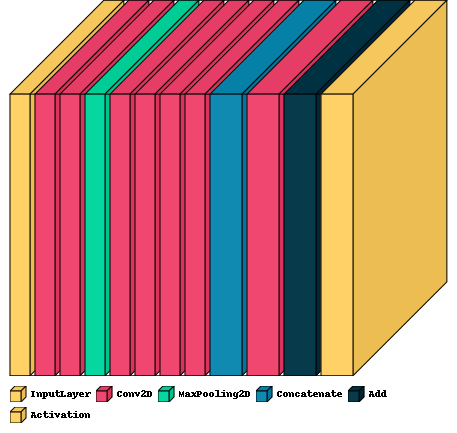

In [ ]:
import visualkeras
import matplotlib.pyplot as plt

i = InceptionBlock(16, 32)

visualkeras.layered_view(i, legend=True,spacing=5,scale_xy=1.1, scale_z=1, max_z=5000,to_file='inception_block.png')



In [ ]:
g = gan.generator
visualkeras.layered_view(g, legend=True,spacing=5,to_file='generator.png',scale_xy=1, scale_z=1, max_z=5000)

In [ ]:
d = gan.discriminator
visualkeras.layered_view(g,legend=True,spacing=5,to_file='discrim.png',scale_xy=1, scale_z=1, max_z=5000)

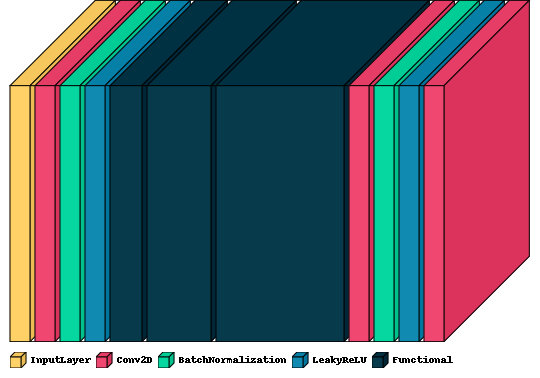

In [ ]:
cover_input = Input(shape=input_shape, name='cover_input')
secret_input = Input(shape=input_shape, name='secret_input')

combined_input = Concatenate(axis=-1)([cover_input, secret_input])

x = Conv2D(16, (3, 3), padding='same')(combined_input)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)

x = InceptionBlock(16, 32)(x)
x = InceptionBlock(32, 64)(x)
x = InceptionBlock(64, 128)(x)
# x = InceptionBlock(128, 256)(x)
# x = InceptionBlock(256, 128)(x)
# x = InceptionBlock(128, 64)(x)
# x = InceptionBlock(64, 32)(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)

stego = Conv2D(3, (1, 1), padding='same', activation='tanh', name="stego_image")(x)
encoder = Model(inputs= combined_input, outputs=stego)

# d = gan.discriminator
visualkeras.layered_view(encoder,legend=True,spacing=5,to_file='encoder.png',scale_xy=1, scale_z=1, max_z=5000)

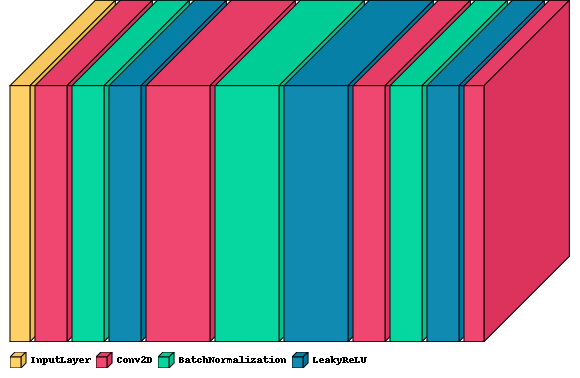

In [ ]:
depth = 32
L1 = Conv2D(depth, 3, padding='same')(stego)
L1 = BatchNormalization(momentum=0.9)(L1)
L1 = LeakyReLU(alpha=0.2)(L1)

L2 = Conv2D(depth*2, 3, padding='same')(L1)
L2 = BatchNormalization(momentum=0.9)(L2)
L2 = LeakyReLU(alpha=0.2)(L2)

L5 = Conv2D(depth, 3, padding='same')(L2)
L5 = BatchNormalization(momentum=0.9)(L5)
L5 = LeakyReLU(alpha=0.2)(L5)

out = Conv2D(3, 1, padding='same', activation='tanh', name="dec_output")(L5)
decoder_output = out

decoder = Model(stego,out)
visualkeras.layered_view(decoder,legend=True,spacing=5,to_file='deccoder.png',scale_xy=1, scale_z=1, max_z=5000)

### Loading the saved training history to plot the training loss

In [ ]:
import pickle
h= simple_gan.history

filename = "./training_history.pkl"
with open(filename, 'wb') as file:
    pickle.dump(h, file)
print(f'Training history saved to {filename}')

NameError: name 'simple_gan' is not defined

In [ ]:
his= None
filename = "./training_history.pkl"
with open(filename, 'rb') as file:
    his = pickle.load(file)


### Plotting the Training Loss

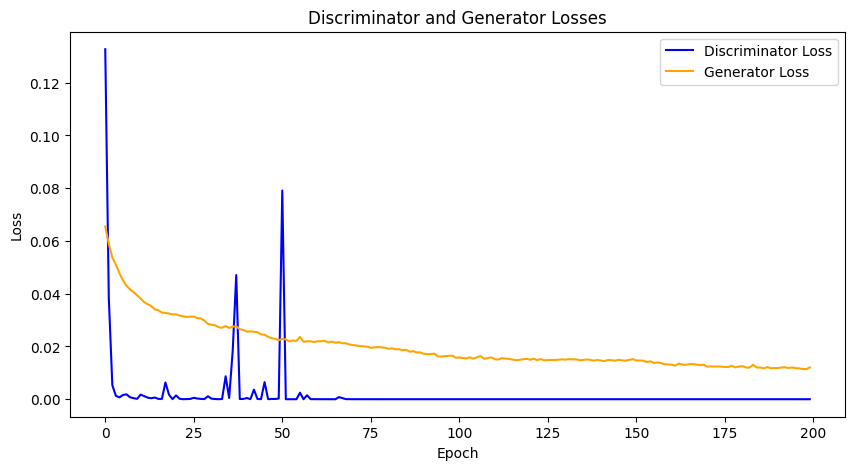

In [ ]:
import matplotlib.pyplot as plt


discriminator_loss = his['d_loss']
generator_loss = his['g_loss']

plt.figure(figsize=(10, 5))
plt.plot(discriminator_loss, label='Discriminator Loss', color='blue')
plt.plot(generator_loss, label='Generator Loss', color='orange')
plt.title(f'Discriminator and Generator Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_plots/plotted_loss.png', dpi =700)
plt.show()



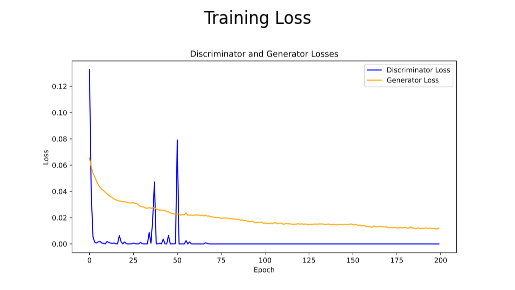

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
def load_and_plot_image(image_path):
    # Load the image using Pillow
    image = Image.open(image_path)

    # Plot the image
    plt.imshow(image)
    plt.title('Training Loss')
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Replace 'your_image_path.jpg' with the actual path to your image
load_and_plot_image('./loss_plots/plotted_loss.png')


## Inference

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
generator = load_model('/content/drive/MyDrive/models/Generator_200.h5')

In [6]:
image_size = 256

def load_images(cover_path, secret_path):
  # load the images
    cover = load_img(cover_path, target_size=(image_size,image_size))
    secret = load_img(secret_path, target_size=(image_size,image_size))

    cover_arr = img_to_array(cover)
    secret_arr = img_to_array(secret)

  # Apply the image normalization that changes the pixel values to [-1, 1]
    cover_image = (cover_arr / 255.0) * 2.0 - 1.0

    secret_image = (secret_arr / 255.0) * 2.0 - 1.0


    return cover_image, secret_image



In [21]:
# # not so good results
# cover_path = '/content/drive/MyDrive/stegano_lite_set/cover_images/cover_image/10018_cover.JPEG'
# secret_path = '/content/drive/MyDrive/stegano_lite_set/secret_images/secret_image/1030_secret.JPEG'


# pretty good results
# cover_path = '/content/drive/MyDrive/stegano_lite_set/test/cover_images/photo-1497215728101-856f4ea42174.jpg'
# secret_path = '/content/drive/MyDrive/stegano_lite_set/test/secret_images/photo-1635961749515-177ce449cfb2.jpg'

#
# cover_path = '/content/drive/MyDrive/stegano_lite_set/test/cover_images/photo-1557720667-093b45dde7b9.jpg'
# secret_path = '/content/drive/MyDrive/stegano_lite_set/test/secret_images/photo-1635683844800-fe8473ac25c2.jpg'


cover_path = '/content/drive/MyDrive/stegano_lite_set/test/cover_images/photo-1520901311353-76c9032606fb.jpg'
secret_path = '/content/drive/MyDrive/stegano_lite_set/test/secret_images/photo-1635959565667-aeb00a4297ba.jpg'

cover, secret = load_images(cover_path, secret_path)

c = np.expand_dims(cover, axis=0)
s = np.expand_dims(secret, axis=0)

result = generator.predict([c, s])


1/1 [==============================] - 0s 21ms/step


In [22]:

# removing the batch dimensions
stego = np.squeeze(result[0])
reconstructed_secret = np.squeeze(result[1])


In [23]:
# converting the pixel values of stego and cover images from [-1, 1] to [0, 1]
stego_img = (stego + 1) / 2.0
cover_img = (cover + 1) / 2.0

# converting the pixel values of secret and re-constructed images from [-1, 1] to [0, 1]
secret_img = (secret + 1) / 2.0
re_constructed_secret_img = (reconstructed_secret+ 1) / 2.0

# adding the batch dimension for calculating the ssim
# tf.image.ssim()  take in images as (batch, height, width, color_channel)
stego_img_batch = np.expand_dims(stego_img, axis=0)
cover_img_batch = np.expand_dims(cover_img, axis=0)

secret_img_batch = np.expand_dims(secret_img, axis=0)
re_constructed_secret_batch = np.expand_dims(re_constructed_secret_img, axis=0)



ssim_of_cover_and_stego = tf.image.ssim(stego_img_batch, cover_img_batch, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)



ssim_of_secret_and_reconstructed = tf.image.ssim(secret_img_batch, re_constructed_secret_batch, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

print(f'\tSSIM of Cover Image and Stego-image: {ssim_of_cover_and_stego}\n\tSSIM of Secret Image and Re-constructed secret image: {ssim_of_secret_and_reconstructed}')

	SSIM of Cover Image and Stego-image: [0.95829064]
	SSIM of Secret Image and Re-constructed secret image: [0.88806707]


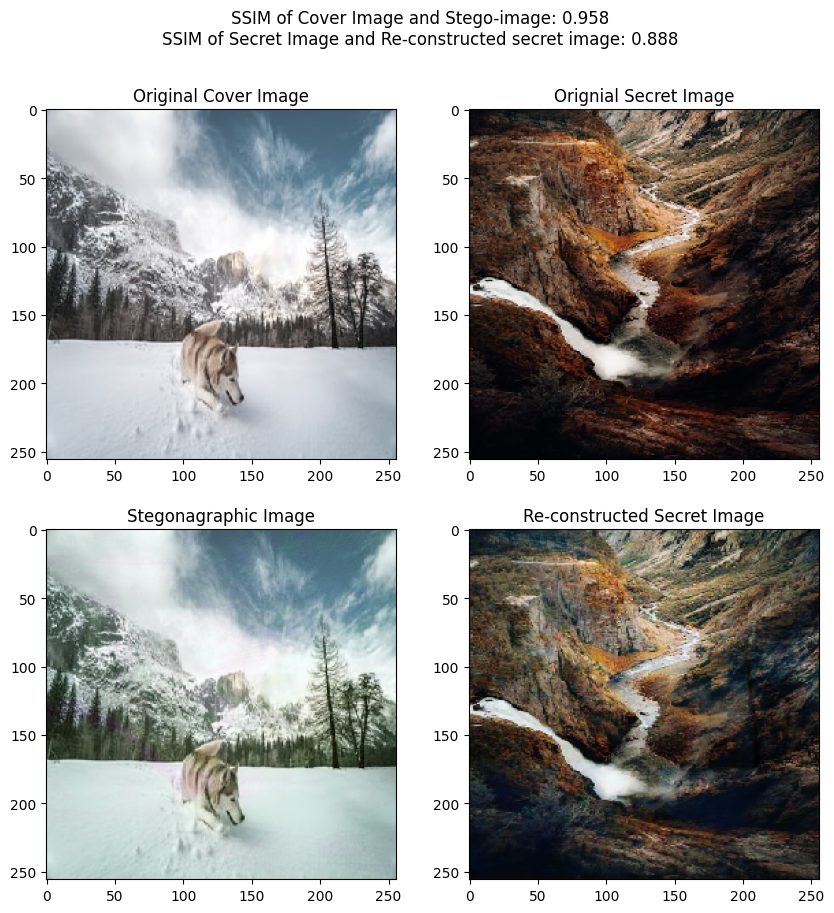

In [24]:
plt.figure(figsize=(10,10))

plt.suptitle(f'SSIM of Cover Image and Stego-image: {ssim_of_cover_and_stego[0]:.3f}\nSSIM of Secret Image and Re-constructed secret image: {ssim_of_secret_and_reconstructed[0]:.3f}')

plt.subplot(2,2,1)
plt.imshow(cover_img)
plt.title('Original Cover Image')

plt.subplot(2,2,2)
plt.imshow(secret_img)
plt.title('Orignial Secret Image')


plt.subplot(2,2,3)
plt.imshow(stego_img)
plt.title('Stegonagraphic Image')

plt.subplot(2,2,4)
plt.imshow(re_constructed_secret_img)
plt.title('Re-constructed Secret Image')
plt.savefig("ssim")
plt.show()

## That complex model definition

**class** SteganographyGAN(object):
    def __init__(self):

        self.generator = self.build_generator(input_shape)

        # Generate discriminator model
        self.discriminator = self.build_discriminator(input_shape)

        # Compile discriminator
        self.discriminator.compile(optimizer='adam', loss='binary_crossentropy')

        # Generate adversarial model
        cover_image = Input(shape=(256, 256, 3), name="Cover_Image_Input")
        secret_image = Input(shape=(256, 256,3), name="Secret_Image_Input")
        stego_image, reconstructed_image = self.generator([cover_image, secret_image])

        # For the adversarial model, we do not train the discriminator
        self.discriminator.trainable = False

        # The discriminator determines the security of the stego image
        security = self.discriminator(stego_image)

        # Define a coef for the contribution of discriminator loss to total loss
        delta = 0.001
        # Build and compile the adversarial model
        self.adversarial = Model(inputs=[cover_image, secret_image], \
                                 outputs=[stego_image, reconstructed_image, security], name="Steganography_GAN")

        self.adversarial.compile(optimizer='adam',loss=['mse', 'mse', 'binary_crossentropy'],loss_weights=[1.0, 0.85, delta])

        self.adversarial.summary()

        self.history = {'epoch':[], 'd_loss': [], 'g_loss': []}

    def build_generator(self,input_shape):
                # Inputs design
        cover_input = Input(shape=input_shape, name='cover_input')
        secret_input = Input(shape=input_shape, name='secret_input')

        combined_input = Concatenate(axis=-1)([cover_input, secret_input])

        x = Conv2D(16, (3, 3), padding='same')(combined_input)
        x = BatchNormalization(momentum=0.9)(x)
        x = LeakyReLU(0.2)(x)

        x = InceptionBlock(16, 32)(x)
        x = InceptionBlock(32, 64)(x)
        x = InceptionBlock(64, 128)(x)
        x = InceptionBlock(128, 256)(x)
        x = InceptionBlock(256, 128)(x)
        x = InceptionBlock(128, 64)(x)
        x = InceptionBlock(64, 32)(x)

        x = Conv2D(16, (3, 3), padding='same')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = LeakyReLU(0.2)(x)

        stego = Conv2D(3, (1, 1), padding='same', activation='tanh', name="stego_image")(x)

        # encoder_output = Concatenate(axis=1)([stego, cover_cc])
        encoder_output = stego

        # Decoder as defined in Table 2
        depth = 32
        L1 = Conv2D(depth, 3, padding='same')(stego)
        L1 = BatchNormalization(momentum=0.9)(L1)
        L1 = LeakyReLU(alpha=0.2)(L1)

        L2 = Conv2D(depth*2, 3, padding='same')(L1)
        L2 = BatchNormalization(momentum=0.9)(L2)
        L2 = LeakyReLU(alpha=0.2)(L2)

        L3 = Conv2D(depth*4, 3, padding='same')(L2)
        L3 = BatchNormalization(momentum=0.9)(L3)
        L3 = LeakyReLU(alpha=0.2)(L3)

        L4 = Conv2D(depth*2, 3, padding='same')(L3)
        L4 = BatchNormalization(momentum=0.9)(L4)
        L4 = LeakyReLU(alpha=0.2)(L4)

        L5 = Conv2D(depth, 3, padding='same')(L4)
        L5 = BatchNormalization(momentum=0.9)(L5)
        L5 = LeakyReLU(alpha=0.2)(L5)

        out = Conv2D(3, 1, padding='same', activation='tanh', name="dec_output")(L5)
        decoder_output = out
        generator = Model(inputs=[cover_input, secret_input], outputs=[encoder_output, decoder_output], name="Generator")
        # generator.summary()
        return generator

    def build_discriminator(self,input_shape):
        img_input = Input(shape=input_shape, name='Discrimator_input')
        L1 = Conv2D(8, 3, padding='same')(img_input)
        L1 = BatchNormalization(momentum=0.9)(L1)
        L1 = LeakyReLU(alpha=0.2)(L1)
        L1 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L1)

        L2 = Conv2D(16, 3, padding='same')(L1)
        L2 = BatchNormalization(momentum=0.9)(L2)
        L2 = LeakyReLU(alpha=0.2)(L2)
        L2 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L2)

        L3 = Conv2D(32, 1, padding='same')(L2)
        L3 = BatchNormalization(momentum=0.9)(L3)
        L3 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L3)

        L4 = Conv2D(64, 1, padding='same')(L3)
        L4 = BatchNormalization(momentum=0.9)(L4)
        L4 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L4)

        L5 = Conv2D(128, 3, padding='same')(L4)
        L5 = BatchNormalization(momentum=0.9)(L5)
        L5 = LeakyReLU(alpha=0.2)(L5)
        L5 = AveragePooling2D(pool_size=5, strides=2, padding='same')(L5)
        F = Flatten()(L5)
        # L6 = SpatialPyramidPooling([1, 2, 4])(L5)
        L7 = Dense(128)(F)
        L8 = Dense(1, activation='sigmoid', name="D_output")(L7)

        discriminator = Model(inputs=img_input, outputs=L8, name='Discriminator')
        # discriminator.summary()

        return discriminator

    def train(self, epochs, batch_size):

        cover_images,secret_images = load_data()
        model_dir = './checkpoints'

        # Adversarial ground truths
        original = np.ones((batch_size, 1))
        encrypted = np.zeros((batch_size, 1))

        for epoch in range(1, epochs+1):
          batch= 1
          for batch_cover_images,batch_secret_images in zip(cover_images,secret_images):
              # Predict the generator output for these images
              imgs_stego, _ = self.generator.predict([batch_cover_images, batch_secret_images])
              # imgs_stego, _, _ = self.adversarial.predict([imgs_cover, imgs_gray])

              # Train the discriminator
              d_loss_real = self.discriminator.train_on_batch(batch_cover_images, original)
              d_loss_encrypted = self.discriminator.train_on_batch(imgs_stego, encrypted)
              d_loss = 0.5 * np.add(d_loss_real, d_loss_encrypted)

              # Train the generator
              g_loss = self.adversarial.train_on_batch([batch_cover_images, batch_secret_images], [batch_cover_images, batch_secret_images, original])
              # Print the progress
              print(f'Epoch:{epoch}/{epochs} Batch:{batch}/{len(cover_images)} [D loss: {d_loss}] [G loss: {g_loss[0]}]')
              batch +=1
          self.history['epoch'].append(epoch)
          self.history['d_loss'].append(d_loss)
          self.history['g_loss'].append(g_loss[0])

          self.generator.save(model_dir+f'/Epoch{epoch}/Generator_{epoch}.h5')
          self.discriminator.save(model_dir+f'/Epoch{epoch}/Discriminator_{epoch}.h5')
          self.adversarial.save(model_dir+f'/Epoch{epoch}/GAN_{epoch}.h5')